<h2>How to create your own Custom Agents</h2>

<h3>Introduction</h3>

We will be creating an agent from scratch using the Amazon Bedrock Converse API. <strong>This is useful when the existing tools in popular frameworks don't support the type of agent you want to build, or if they have extra bit of code that you don't need for your specific use case or is slowing down your application. Building an agent from scratch also helps you understand how agents work internally.</strong>

Before we start, let's cover a few important concepts.

Agents are systems that use Large Language Models (LLMs) as their reasoning engines to decide what actions to take and what inputs to provide. After executing actions, the results can be fed back into the LLM to determine if more actions are needed or if it's okay to finish.

Agents have access to different tools or functions that allow the LLM to interact with external APIs and automate tasks, resolve queries, and much more.

In this tutorial, we will build a simple agent from scratch that can access a web search engine and a Python code executor. We will be able to ask questions, watch the agent call the search tool and the Python code executor tool, and have a conversation with it.

<h3>Architecture</h3>

Following is the Architecture Daigram,

<img src="./assets/custom_agent.drawio.png" alt="Custom Agent Architecture" style="margin:auto">


When the user makes the query, the custom agent code receives it and then it orchestrates the interaction between the Foundational Model/LLM and its tools. These tools can be any custom code, Lambda Function, Database or even any Rest API hosted in the internet.

The custom agent code takes care of configuring the LLM calls such that LLM knows about the tools available to it, then it also takes care of function calling when the LLM deems them necessary and supplying the function responses back to LLM after receving the output back from the functions to generate the final answer.


<h3>Imports and Setting up boto3 connections</h3>

In [1]:
!pip install -Uq langchain_experimental==0.0.64 duckduckgo-search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai-magics 2.18.1 requires langchain<0.2.0,>=0.1.0, but you have langchain 0.2.15 which is incompatible.


In [2]:
import json
import io
from IPython.display import display
from duckduckgo_search import DDGS

import pprint
import random
import boto3
import sys
from io import StringIO
import copy

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
region = 'us-west-2'

session = boto3.session.Session(region_name=region)
bedrock_client = session.client('bedrock-runtime')

<h3>Defining the Tools</h3>

The first step in creating our Agent is to define the tools it can access. In our case, we'll be defining local Python functions, but it's important to note that these tools could be any type of application service. On AWS, these tools might include:
<ul>
<li>An AWS Lambda function</li>
<li>A connection to an Amazon RDS database</li>
<li>An Amazon DynamoDB table</li>
</ul>
Other examples of tools could be:
<ul>
<li>REST APIs</li>
<li>Data warehouses, data lakes, and databases</li>
<li>Computation engines</li>
</ul>
For our Agent, we'll define two tools as Python functions with the following abilities:
<ol>
<li>Retrieve web search results from the DuckDuckGo search engine using natural language as input.</li>
<li>Execute Python code provided by the Agent to generate charts using the Matplotlib library.</li>
</ol>
In simple terms, we're giving our Agent access to two tools: one that can perform web searches based on natural language queries, and another that can create visual charts and graphs from Python code. These tools will enable our Agent to gather information and present it in a visual format, which can be useful for various tasks and applications.

Following code defines two functions: `chat_generator_from_python_code` and `web_search`. The first function executes Python code to generate a chart, handling any exceptions and returning the result. The second function performs a web search using the DDGS (DuckDuckGo Search) library and returns the search results. Additionally, there's a `call_function` utility that will help us orchestrate the function calls by abstracting the tool name.

In [3]:
from langchain_experimental.utilities import PythonREPL

def chat_generator_from_python_code(code: str) -> str:
    """
    Function to executes the python code to generate the chart.
    Args:
        code: The python code that will generate the chart.
    """
    repl = PythonREPL()
    try:
        result = repl.run(code)
    except Exception as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Code has generated the chart successfully.\n{result}"
    return result_str


def web_search(query: str) -> str:
    """
    Function to research and collect more information to answer the query
    Args:
        query: The query that needs to be answered or more information needs to be collected.
    """
    try:
        results = DDGS().text(keywords=query, region='in-en', max_results=5)
        return '\n'.join([json.dumps(result) for result in results])
    except Exception as e:
        return f"Failed to search. Error: {e}"


def call_function(tool_name, parameters):
    func = globals()[tool_name]
    output = func(**parameters)
    return output

Following is a sample execution of the web search function.

In [4]:
query = "What is the capital of India"
print(f"Query for Web search: \n{query}")
data = call_function('web_search', {'query': query})

print(f"Following is the output of web search: {data}")

Query for Web search: 
What is the capital of India
Following is the output of web search: {"title": "New Delhi | History, Population, Map, & Facts | Britannica", "href": "https://www.britannica.com/place/New-Delhi", "body": "New Delhi, national capital of India.It is situated in the north-central part of the country on the west bank of the Yamuna River, adjacent to and just south of Delhi city (Old Delhi) and within the Delhi national capital territory.. In December 1911 King George V of Britain decreed that the capital of British India would be moved from Calcutta (now Kolkata) to Delhi.Construction began in 1912 at a site about 3 miles (5 km) south of the Delhi city centre, and the new capital was formally ..."}
{"title": "New Delhi - Wikipedia", "href": "https://en.wikipedia.org/wiki/New_Delhi", "body": "New Delhi (/ \u02c8 nj u\u02d0 \u02c8 d \u025b. l i / \u24d8, [6] Hindi: [\u02c8n\u0259i\u02d0 \u02c8d\u026al\u02d0i\u02d0], ISO: Na\u012b Dill\u012b), is the capital of India and 

Now that we have functions defined that are to be used as tools, we will next define the `toolConfig` in the format required by the Bedrock Converse API to let Agent know about the tools available to it.

Within `toolConfig`, setting `toolChoice` to `{auto: {}}` allows the model to automatically decide if a tool should be called or whether to generate text instead.

In [5]:
toolConfig = {
    'tools': [],
    'toolChoice': {
        'auto': {}
    }
}

The following is a sample of how a function-specific tool schema `toolSpec` of any function appears. The description fields allow the Large Language Models (LLMs) that support function calling to understand the tools available to them, specifically their functionality, when they should be used, and what types of parameter inputs they accept.

In [6]:
toolConfig['tools'].append({
        'toolSpec': {
            'name': 'web_search',
            'description': 'Fetch information about any query from the internet.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'query': {
                            'type': 'string',
                            'description': 'Query for which more information is required.'
                        }
                    },
                    'required': ['query']
                }
            }
        }
    })

<h3>Sample Custom Agent</h3>

Following `agent` class is designed to facilitate the interaction between a user and a language model (LLM) through a conversational interface. This implementation allows the LLM to call a single tool at a time, preventing it from getting stuck in a tool-calling loop. However, extending the functionality to plan and handle a series of tool calls can be implemented, albeit non-trivially.

The class initializes with a `toolConfig`, `system_prompt`, and an optional list of `messages`. The `call_converse_api_with_tools` method invokes the LLM by sending messages and the tool configuration, handling any exceptions that may occur.

The `handle_tool_use` method validates and calls the appropriate tool based on the provided tool name and parameters. If an unexpected tool is used, it raises an exception.

The `process_user_input` method is the core of the class. It appends the user's input to the list of messages, invokes the LLM, and processes the response. If the LLM's response includes tool usage instructions, the method calls the specified tool(s) and incorporates the tool's output into the conversation. This process continues until the LLM provides a final answer or the maximum number of retries is reached.

The `check_for_final_answer` method checks if the LLM's response includes a final answer to the user's query based on the conversation history.

The `invoke` method is the entry point for the user's input. It attempts to obtain a final answer by calling `process_user_input` and `check_for_final_answer` methods up to a maximum number of retries. If a final answer is not found within the specified number of retries, it returns the entire conversation history.

Overall, this agent class provides a conversational interface for users to interact with an LLM while enabling the LLM to leverage external tools. The implementation ensures that the LLM does not get stuck in a tool-calling loop by handling one tool at a time.

In [7]:
class agent:
    def __init__(self, toolConfig, system_prompt, messages=[]):
        self.bedrock_client = bedrock_client
        self.model_id = modelId
        self.messages = messages
        self.max_retires = 10
        self.toolConfig = toolConfig
        self.system_prompt = [
            {
                "text": system_prompt
            }
        ]

    def call_converse_api_with_tools(self, messages):
        try:
            response = self.bedrock_client.converse(
                modelId=self.model_id,
                system=self.system_prompt,
                messages=messages,
                toolConfig=self.toolConfig
            )
            return response
        except Exception as e:
            return {"error": str(e)}

    def handle_tool_use(self, func_name, func_params):
        allowed_tools = [
            tool['toolSpec']['name'] for tool in self.toolConfig['tools']
        ]
        if func_name in allowed_tools:
            results = call_function(func_name, func_params)
            return results
        raise Exception("An unexpected tool was used")

    def process_user_input(self, user_input):
        self.messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "text": user_input
                    }
                ]
            }
        )
        print("Invoking LLM")
        response_message = self.call_converse_api_with_tools(
           messages=self.messages,
        )
        if "error" in response_message:
            return f"An error occurred: {response_message['error']}"
        # Add the intermediate output to the list of messages
        self.messages.append(response_message['output']['message'])
        print("Received message from the LLM")
        function_calling = [
            c['toolUse'] for c in response_message['output']['message']['content'] if 'toolUse' in c
        ]

        if function_calling:
            print(f"Function Calling - List of function calls : {function_calling}")
            tool_result_message = {"role": "user", "content": []}
            for function in function_calling:
                tool_name = function['name']
                tool_args = function['input'] or {}
                print(f"Function calling - Calling Tool :{tool_name}(**{tool_args})")
                tool_response = self.handle_tool_use(tool_name, tool_args)
                print(f"Function calling - Got Tool Response: {tool_response}")
                tool_result_message['content'].append({
                    'toolResult': {
                        'toolUseId': function['toolUseId'],
                        'content': [{"text": tool_response}]
                    }
                })
            # Add the intermediate tool output to the list of messages
            self.messages.append(tool_result_message)
            print("Function calling - Calling LLM with Tool Result")
            response_message = self.call_converse_api_with_tools(
               messages=self.messages
            )
            if "error" in response_message:
                return f"An error occurred: {response_message['error']}"
            # Add the intermediate output to the list of messages
            self.messages.append(response_message['output']['message'])
            print("Function calling - Received message from the LLM")
        return response_message['output']['message']['content'][0]['text']

    def check_for_final_answer(self, user_input, ai_response):
        messages = []
        for message in self.messages:
            _m = {
                'role': message['role'],
                'content': []
            }
            for _c in message['content']:
                if 'text' in _c.keys():
                    _m['content'].append(_c)
                elif 'toolResult' in _c.keys():
                    _m['content'].extend(_c['toolResult']['content'])
            messages.append(_m)
        messages.append({
            "role": "user",
            "content": [
                {
                    "text": f"User Query: {user_input}\nAI Response: {ai_response}"
                }
            ]
        })
        try:
            response = self.bedrock_client.converse(
                modelId=self.model_id,
                system=[
                    {
                        "text": f"""You are an expert at extracting the answer to user's query in the AI's response.
If you are not able to determine whether the query was answered then return: Sorry cannot answer the query. Please try again.
You have previous conversation to provide you the context."""
                    }
                ],
                messages=messages
            )
            print(response)
            return response['output']['message']['content'][0]['text']
        except Exception as e:
            return {"ERROR": str(e)}

    def invoke(self, user_input):
        for i in range(self.max_retires):
            print(f"Trial {i+1}")
            response_text = self.process_user_input(user_input)
            if 'FINAL ANSWER' in response_text:
                print(10*'--')
                return response_text
            else:
                print('LLM Parser Invoked')
                llm_parser_output = self.check_for_final_answer(user_input, response_text)
                print(f'LLM Parser Output: {llm_parser_output}')
                if 'ERROR' not in llm_parser_output:
                    print(10*'--')
                    return llm_parser_output
        return '\n'.join([msg["content"][0].get('text', "<skipped> Tool Use <skipped>") for msg in self.messages])

We will next test the agent that was just defined by providing it with previously defined `toolConfig` and a sample system prompt.

In [8]:
messages = []

system_prompt = """You are a researcher AI.
Your task is to use the tools available to you and answer the user's query to the best of your capabilities.
When you have final answer to the user's query then you are to strictly prefix it with FINAL ANSWER to stop the iterations."""

researcher_agent = agent(system_prompt=system_prompt, toolConfig=toolConfig, messages=messages)

output = researcher_agent.invoke("What is the GDP of India from 2009 to 2020")

print(output)

Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_35IP2n6lS2GJaTg-7PDQkw', 'name': 'web_search', 'input': {'query': 'India GDP 2009 to 2020'}}]
Function calling - Calling Tool :web_search(**{'query': 'India GDP 2009 to 2020'})
Function calling - Got Tool Response: {"title": "India GDP 1960-2024 | MacroTrends", "href": "https://www.macrotrends.net/global-metrics/countries/IND/india/gdp-gross-domestic-product", "body": "India gdp for 2020 was $2,671.60B, a 5.78% decline from 2019. India gdp for 2019 was $2,835.61B, a 4.91% increase from 2018. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products."}
{"title": "GDP growth (annual %) - India | Data", "href": "https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=IN", "body": "GDP growth (annual %) - India. World Bank national acco

It is evident that the Agent was capable of invoking the `web_search` tool, gathering the required information, and summarizing it to provide an answer to our query.

Next we shall test the agent by supplying multiple tools so and watch the it answer our queries.

In [9]:
toolConfig = {
    'tools': [
        {
            'toolSpec': {
                'name': 'web_search',
                'description': 'Fetch information about any query from the internet.',
                'inputSchema': {
                    'json': {
                        'type': 'object',
                        'properties': {
                            'query': {
                                'type': 'string',
                                'description': 'Query for which more information is required.'
                            }
                        },
                        'required': ['query']
                    }
                }
            }
        }, {
            'toolSpec': {
                'name': 'chat_generator_from_python_code',
                'description': 'Generates the charts from python code',
                'inputSchema': {
                    'json': {
                        'type': 'object',
                        'properties': {
                            'code': {
                                'type': 'string',
                                'description': 'Syntactically correct Python code that will generate the charts'
                            }
                        },
                        'required': ['code']
                    }
                }
            }
        }
    ],
    'toolChoice': {
        'auto': {}
    }
}


messages = []

system_prompt = """You are a researcher AI.
Your task is to use the tools available to you and answer the user's query to the best of your capabilities.
Any fact or answers that you generate should only be derieved from the response you get from the tools.
When you have final answer or have generated the charts as per the user's query then you are to strictly prefix your response with FINAL ANSWER"""

researcher_agent = agent(
    system_prompt = system_prompt, 
    toolConfig = toolConfig, 
    messages = messages
)
output = researcher_agent.invoke("What is the GDP of USA from 2009 to 2021")
print(output)

Trial 1
Invoking LLM
Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_nR3d-dqeT2GGm9oKT7nFQA', 'name': 'web_search', 'input': {'query': 'US GDP from 2009 to 2021'}}]
Function calling - Calling Tool :web_search(**{'query': 'US GDP from 2009 to 2021'})
Function calling - Got Tool Response: {"title": "U.S. GDP 1960-2024 | MacroTrends", "href": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "body": "U.S. gdp for 2021 was $23,315.08B, a 10.71% increase from 2020. U.S. gdp for 2020 was $21,060.47B, a 1.5% decline from 2019. U.S. gdp for 2019 was $21,380.98B, a 4.13% increase from 2018. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included ..."}
{"title": "United States GDP 1990-2023 | Statista", "href": "https://www.statista.com/statistics/188105/annual-gdp-of-the-united-states-since-199

Trial 1
Invoking LLM


Python REPL can execute arbitrary code. Use with caution.


Received message from the LLM
Function Calling - List of function calls : [{'toolUseId': 'tooluse_4OjysD6sSqqWiDzJ0FPD1g', 'name': 'chat_generator_from_python_code', 'input': {'code': "import matplotlib.pyplot as plt\n\nyears = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]\ngdp = [14628, 14992, 15542, 16197, 16785, 17527, 18224, 18715, 19519, 20611, 21428, 20937, 23000]\n\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp, marker='o')\nplt.xlabel('Year', fontsize=14)\nplt.ylabel('GDP (Billion USD)', fontsize=14)\nplt.title('US GDP from 2009 to 2021', fontsize=16)\nplt.xticks(years[::2])\nplt.grid(True)\nplt.show()"}}]
Function calling - Calling Tool :chat_generator_from_python_code(**{'code': "import matplotlib.pyplot as plt\n\nyears = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]\ngdp = [14628, 14992, 15542, 16197, 16785, 17527, 18224, 18715, 19519, 20611, 21428, 20937, 23000]\n\nplt.figure(figsize=(10, 6))\nplt.plot(yea

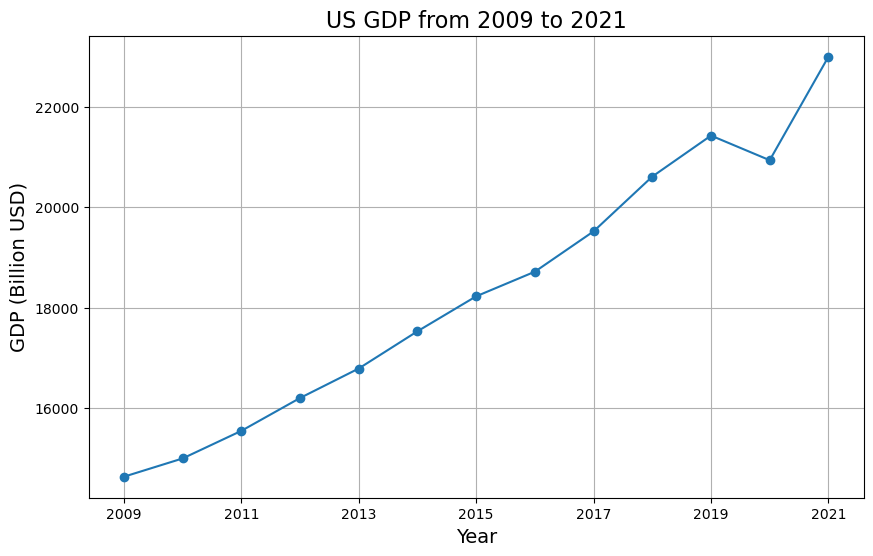

Function calling - Got Tool Response: Code has generated the chart successfully.

Function calling - Calling LLM with Tool Result
Function calling - Received message from the LLM
--------------------
FINAL ANSWER: The line chart plotting the US GDP from 2009 to 2021 is shown below:

[Chart Displaying Line Plot of US GDP from 2009 to 2021]

The chart clearly shows the steady increase in US GDP year-over-year from 2009 to 2019, followed by a dip in 2020 likely due to the COVID-19 pandemic impacts. The GDP then rebounds strongly in 2021 crossing the $23 trillion mark.


In [10]:
output = researcher_agent.invoke("Plot it on a line chart!!")
print(output)

<h3>Summary</h3>

In this notebook we saw how custom python functions can be defined as tools. We also saw a sample implementation of Custom Agent that works with two differnet tools. We interacted with the agent and watched it invoke different tools to as per user's requirements.

<h3>Next Steps</h3>

You can append to the class to add the functionality to plan ahead and use multiple tools to achieve complex tasks.